# Begin pore network modeling

In [2]:
import numpy as np
import openpnm as op
import porespy as ps
import matplotlib.pyplot as plt
import pandas as pd
import os
from openpnm.models import physics as mods
from scipy import stats
from skimage.measure import euler_number

np.random.seed(10)
resolution = 2.32e-06
im_shape = 128
snwp = np.arange(0, 1.005, 0.005)


def get_physics(gen_physics):
    gen_physics.add_model(propname='throat.hydraulic_conductance',
                model=mods.hydraulic_conductance.classic_hagen_poiseuille)
    gen_physics.add_model(propname='throat.entry_pressure',
                model=mods.capillary_pressure.washburn)
    return gen_physics



im = np.load('1.npy')
ws = op.Workspace()
resolution = 2.25e-6 
snow = ps.networks.snow(
im=im,
voxel_size=resolution)

proj = op.io.PoreSpy.import_data(snow)
pn,geo = proj[0],proj[1]

health = pn.check_network_health()
op.topotools.trim(network=pn, pores=health['trim_pores'])


# define phase and physics
# assuming temperature is 
air = op.phases.Air(network=pn)
water = op.phases.Water(network=pn)
air['pore.contact_angle'] = 180
water['pore.contact_angle'] = 0
water['pore.surface_tension'] = 0.064
air['pore.surface_tension'] = 0.064

phys_air = op.physics.GenericPhysics(network=pn, phase=air, geometry=geo)
phys_water=op.physics.GenericPhysics(network=pn, phase=water, geometry=geo)
phys_air = get_physics(phys_air)
phys_water = get_physics(phys_water)


------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  249
Peaks after trimming saddle points:  143
Peaks after trimming nearby peaks:  143
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 244/244 [00:01<00:00, 229.76it/s]


# set up physics and perform invasion percolation

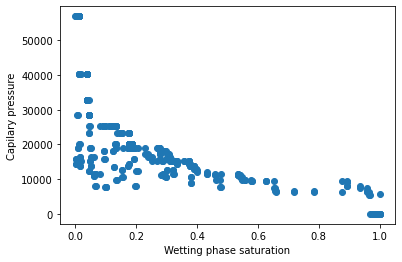

In [3]:
inlets = pn.pores('bottom')
outlets = pn.pores('top')
ip = op.algorithms.InvasionPercolation(network=pn)
ip.setup(phase=air)
ip.set_inlets(pores=inlets)
ip.run()

data = ip.get_intrusion_data()
sw = [1-x for x in data.S_tot]
snw = data.S_tot
f = plt.figure()
plt.scatter(sw,data.Pcap)
plt.xlabel('Wetting phase saturation')
plt.ylabel('Capilary pressure')
pc_data = {'Sw':np.array(sw),'Pc':np.array(data.Pcap)}
pc_data = pd.DataFrame(pc_data)
# pc_data.to_excel('pc-data_ip.xlsx')

#### Define functions help update physics for different phases

In [4]:
def update_phase_and_phys_water(results):
    val = np.amin(phys_water['throat.hydraulic_conductance'])/1000

    # results: pore and throats occupancy
    air.update(results)
    # if stokes flow of water, we need to update phys_water hydraulic conductance.
    #  The percoaltion result is always refering to air since this is phase we we are using to invade
    # Therefore, locations where water hydraulic conductance is slow indicate gas saturated
    phys_water['throat.hydraulic_conductance'][air['throat.occupancy']] = val

def update_phase_and_phys_air(results):
    val = np.amin(phys_water['throat.hydraulic_conductance'])/1000
    # results: pore and throats occupancy
    air.update(results)
    # if stokes flow of air, we need to update phys_air hydraulic conductance.
    # Therefore, locations where air hydraulic conductance is slow indicate water saturated
    phys_air['throat.hydraulic_conductance'][~air['throat.occupancy']] = val

def stokes_flow(phase,inlet,outlet):
    st = op.algorithms.StokesFlow(network=pn)
    st.setup(phase=phase)
    # in boundary front water saturation is 1
    # Boundary pores with constant condition
    # left is the inlet of flow
    st.set_value_BC(pores=pn.pores(inlet), values=0)
    # outlet of flow
    st.set_value_BC(pores=pn.pores(outlet), values=1) # this part needs some validation
    st.run()
    return st

def cal_absolute_perm(image_size,resolution,Q):
    A = (image_size*image_size) *resolution**2 # m^2
    L = image_size * resolution # m
    mu = water['pore.viscosity'].max() # N s/m^2 or Pa s
    delta_P = 1 # 1-0
    K = Q * L * mu / (A * delta_P)
    return K/0.98e-12*1000

def cal_eff_perm(image_size,resolution,Q,phase):
    A = (image_size*image_size) *resolution**2
    L = image_size * resolution
    mu = phase['pore.viscosity'].max() # N s/m^2 or Pa s
    delta_P = 1
    K = Q * L * mu / (A * delta_P)

    return K/0.98e-12*1000

##### calculate absolute permeability

In [5]:
im_shape = 128
resolution = 2.32e-06

# absolute permeability of water
phys_water.regenerate_models()
st = op.algorithms.StokesFlow(network=pn)
st.setup(phase=water)
# in boundary front water saturation is 1
# Boundary pores with constant condition
# left is the inlet of flow
st.set_value_BC(pores=inlets, values=0)
# outlet of flow
st.set_value_BC(pores=outlets, values=1) # this part needs some validation
st.run()

Q_abs_water = st.rate(pores=outlets,mode='group')
kabs_water = cal_absolute_perm(im_shape,resolution,Q_abs_water[0])
print(f'Absolute permeability is {kabs_water}md')
proj.purge_object(obj=st)

Absolute permeability is 43.98190912381538md


#### Calculate effective permeability of water

In [6]:
keff_water = []
phys_water.regenerate_models()

# 100 points
snw = np.arange(0, 1.01, 0.01)

for s in snw:
    update_phase_and_phys_water( ip.results(Snwp=s) )
    st = op.algorithms.StokesFlow(network=pn)
    st.setup(phase=water)
    st.set_value_BC(pores=inlets, values=0)
    st.set_value_BC(pores=outlets, values=1)
    st.run()
    Q = st.rate(pores=outlets,mode='group')[0]
    keff = cal_eff_perm(im_shape,resolution,Q,water)
    keff_water.append(keff)
    proj.purge_object(obj=st)
    phys_water.regenerate_models()

#### Calculate effective permeability of air

In [7]:
keff_air = []
phys_air.regenerate_models()

for s in snw:
    update_phase_and_phys_air( ip.results(Snwp=s) )
    st = op.algorithms.StokesFlow(network=pn)
    st.setup(phase=air)
    st.set_value_BC(pores=inlets, values=0)
    st.set_value_BC(pores=outlets, values=1)
    st.run()
    Q = st.rate(pores=outlets,mode='group')[0]
    keff = cal_eff_perm(im_shape,resolution,Q,air)
    keff_air.append(keff)
    proj.purge_object(obj=st)
    phys_air.regenerate_models()

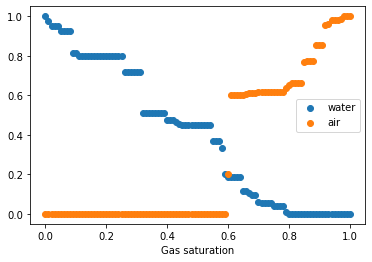

In [8]:
kr_water = np.array(keff_water)/kabs_water
kr_air = np.array(keff_air)/kabs_water
kr_data = {'Snw':snw,'kr_air':kr_air,'kr_water':kr_water}
kr_data =pd.DataFrame(kr_data)

f = plt.figure()
plt.scatter(snw,np.array(keff_water)/kabs_water,label='water')
plt.scatter(snw,np.array(keff_air)/kabs_water,label='air')
plt.xlabel('Gas saturation')
plt.legend()